In [194]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 

In [195]:

def find_repo_root(start_path):
    current_path = os.path.abspath(start_path)
    
    while True:
        # Check for the existence of the .git directory or other indicators
        if os.path.isdir(os.path.join(current_path, '.git')) or \
           os.path.isfile(os.path.join(current_path, 'README.md')):
            return current_path
        
        parent_path = os.path.dirname(current_path)
        
        # Stop if we reach the root directory
        if parent_path == current_path:
            break
        
        current_path = parent_path

    return None  # Return None if not found

root = find_repo_root(os.getcwd())
root

'c:\\Users\\fitsl\\Documents\\Programming\\UVM Programming Classes\\Data Science I\\Project'

In [196]:
df1 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_1.parquet")
df2 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_2.parquet")
df3 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_3.parquet")
df4 = pd.read_parquet(f"{root}/Data/Storm events/events_db_chunk_4.parquet")

df = pd.concat([df1, df2, df3, df4])
df['State FIPS'] = df['State FIPS'].apply(lambda x: f"{int(x):02d}")
df['County/Zone FIPS'] = df['County/Zone FIPS'].apply(lambda x: f"{int(x):03d}")
df['FIPS'] = df['State FIPS'] + df['County/Zone FIPS']
df = df[df['Year'] >= 2000]

In [197]:
df['Property Damage'].value_counts()
def convert_to_number(value):
    if pd.isna(value):
        return 0
    value = value.strip().lower()
    if value == 'k':
        return 1000
    elif value.endswith('k'):
        return int(float(value[:-1]) * 1000)
    elif value.endswith('m'):
        return int(float(value[:-1]) * 1000000)
    elif value.endswith('h'):
        return int(float(value[:-1]) * 100)
    elif value.endswith('b'):
        return int(float(value[:-1]) * 1000000000)
    else:
        return 0
    

def fk_log10(num):
    if num == 0: return 0
    else: return np.log10(num)
    

In [198]:
df['property_num'] = df['Property Damage'].map(lambda x : convert_to_number(x))
df['property_num'].value_counts()
df['property_log'] = df['property_num'].map(lambda x: fk_log10(x))

In [199]:
df.columns

Index(['OBJECTID', 'State', 'Month', 'Event Type', 'Begin Date Time',
       'Property Damage', 'Begin Lat', 'Begin Lon', 'Episode Narrative',
       'Event Narrative', 'Lat/Lon Known', 'State FIPS', 'Year',
       'County/Zone FIPS', 'County/Zone Type', 'Event ID', 'Direct Injuries',
       'Indirect Injuries', 'Indirect Deaths', 'Direct Deaths', 'Episode ID',
       'Source', 'Data Source', 'Tornado F Scale', 'County/Zone Name',
       'Total Injuries and Deaths', 'x', 'y', 'FIPS', 'property_num',
       'property_log'],
      dtype='object')

In [200]:
df['deaths'] = df['Direct Deaths'] + df['Indirect Deaths']
df['injuries'] = df['Direct Injuries'] + df['Indirect Injuries']

In [201]:
a = df['injuries'].value_counts()
a = a.reset_index()
a = a.sort_values(by='injuries', ascending=False)
a.head(50)

,injuries,count
93,2400,1
111,1150,1
112,800,1
72,700,2
95,519,1
131,500,1
129,468,1
117,450,1
86,437,1
94,422,1


<Axes: xlabel='property_log', ylabel='Count'>

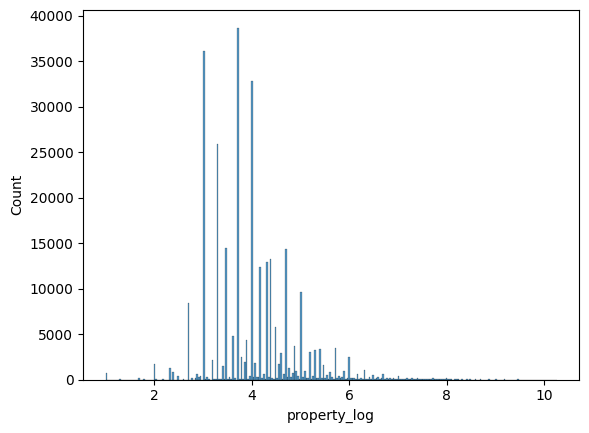

In [202]:
sns.histplot(data=df[df['property_log']>0], x='property_log')

<Axes: xlabel='deaths'>

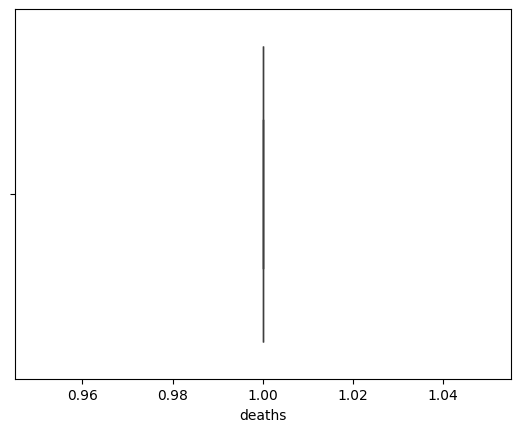

In [203]:
sns.boxplot(data=df[df['deaths']>0], x='deaths', showfliers=False)

In [204]:
df.sort_values(by='deaths', ascending=False, inplace=True)
df[['deaths', "Indirect Deaths", "Direct Deaths"]]

,deaths,Indirect Deaths,Direct Deaths
687675,638,0,638
1084469,161,3,158
687699,140,0,140
686823,97,0,97
1677740,87,0,87
...,...,...,...
420172,0,0,0
420173,0,0,0
420174,0,0,0
420175,0,0,0


<Axes: xlabel='deaths_log', ylabel='Count'>

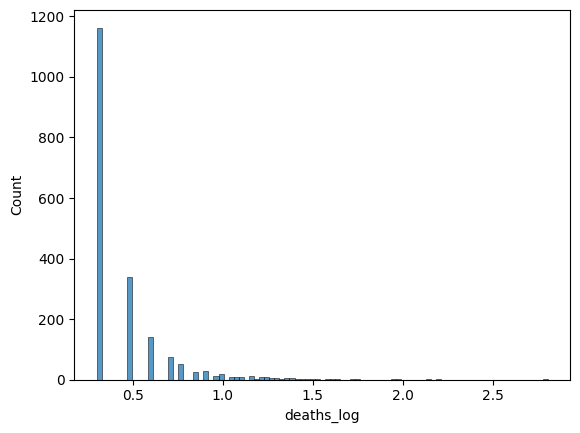

In [205]:
df['deaths_log'] = df['deaths'].apply(lambda x : fk_log10(x))
sns.histplot(data=df[df['deaths_log'] >0], x='deaths_log')

## Classic power law!

In [206]:
def property_cater(plog):
    if plog <= 2: 
        return 1
    elif plog <= 3:
        return 2
    elif plog <= 4:
        return 3
    elif plog <= 5:
        return 4
    elif plog <= 7:
        return 5
    elif plog <= 9:
        return 6
    else:
        return 7

def death_cater(count):
    if count == 0:
        return 1
    elif count <= 1:
        return 2
    elif count <= 10:
        return 3
    elif count <= 50:
        return 4
    elif count <= 100:
        return 5
    elif count <= 500:
        return 6
    else: return 7
    

In [207]:
df['injury_cat'] = df['injuries'].apply(
    lambda x : death_cater(x))
df['death_cat'] = df['deaths'].apply(
    lambda x: death_cater(x))
df['property_cat'] = df['property_num'].apply(
    lambda x: property_cater(x))

In [208]:
# Determine the size of each split
split_size = len(df) // 4

# Split and save each part as a Parquet file
for i in range(4):
    start_index = i * split_size
    # Handle the last chunk to include any remaining rows
    end_index = None if i == 3 else (i + 1) * split_size
    df_part = df.iloc[start_index:end_index]
    df_part.to_parquet(
        f'{root}/Data/Storm events/Cleaned/cleaned_stormevents_{i+1}.parquet', engine='pyarrow', index=False
        )